In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [12]:
def open_data(filename):
    return pd.read_csv(filename, delimiter=' ').values

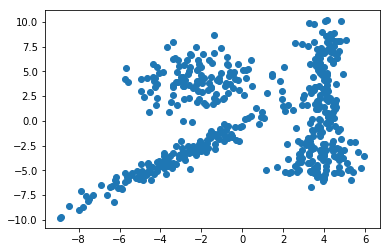

In [13]:
train = open_data('EMGaussian.data')

plt.scatter(train[:, 0], train[:, 1])

In [1130]:
class KMeans:
    def __init__(self, k=2, tol=1e-3):
        self.k = k
        self.tol = tol
        
    def fit(self, X):
        self.k_centers = 2*X.std()*(np.random.random(size=(X.shape[1], self.k))-0.5)
        plt.scatter(km.k_centers[0, :], km.k_centers[1, :], c=range(4), marker='+')
        i = 0
        distortion_new = 0
        
        while i < 2 or np.linalg.norm(distortion - distortion_new) > self.tol:
            distortion = distortion_new
            dists = np.sum((X[:, :, np.newaxis] - self.k_centers)**2, axis=1)
            cluster_assignement = np.argmin(dists, axis=1)
            
            for cluster_n in range(self.k):
                self.k_centers[:, cluster_n] = np.mean(X[cluster_assignement==cluster_n, :], axis=0)
            
            distortion_new = np.sum(np.min(dists, axis=1))
            i += 1
            
        self.distortion = distortion_new
    
    def predict(self, X):       
        dists = np.sum((X[:, :, np.newaxis] - self.k_centers)**2, axis=1)
        cluster_assignement = np.argmin(dists, axis=1)  
        return cluster_assignement

Final distortion is 47957.07059901404


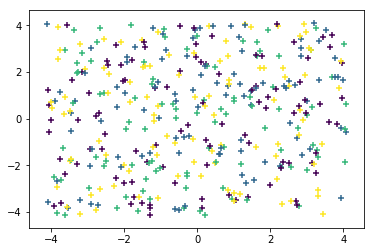

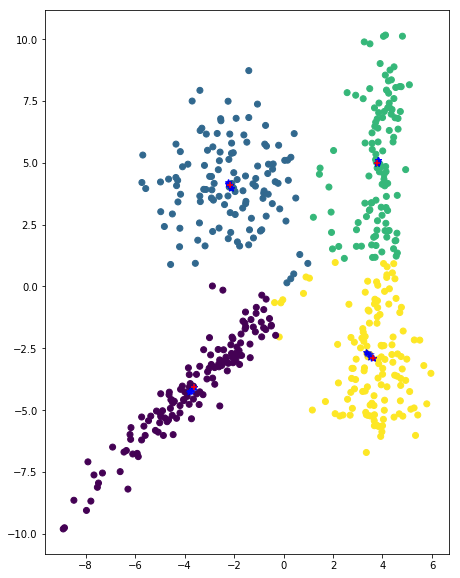

In [1131]:
km = KMeans(k=4)
distortions = []
centers = []
for i in range(100):
    km.fit(train)
    distortions.append(km.distortion)
    centers.append(km.k_centers)

plt.figure(figsize=(10, 10))
plt.scatter(train[:, 0], train[:, 1], c=km.predict(train))
for c in centers:
    plt.scatter(c[0, :], c[1, :], c='blue', marker='*', alpha=0.1)
plt.scatter(km.k_centers[0, :], km.k_centers[1, :], c='red', marker='+')
plt.gca().set_aspect('equal', adjustable='box')

print("Final distortion is {}".format(km.distortion))


(array([11.,  0.,  2., 11.,  1.,  0., 15.,  0.,  0.,  0.,  0.,  2.,  0.,
        10., 10.,  5.,  5.,  0.,  1., 27.]),
 array([44971.95758555, 45121.21323623, 45270.4688869 , 45419.72453757,
        45568.98018825, 45718.23583892, 45867.49148959, 46016.74714026,
        46166.00279094, 46315.25844161, 46464.51409228, 46613.76974296,
        46763.02539363, 46912.2810443 , 47061.53669498, 47210.79234565,
        47360.04799632, 47509.303647  , 47658.55929767, 47807.81494834,
        47957.07059901]),
 <a list of 20 Patch objects>)

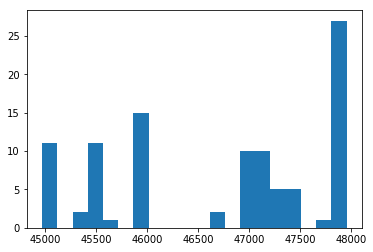

In [1128]:
distortions = np.array(distortions)
plt.hist(distortions[distortions<=60000], bins=20)

In [1097]:
def mat_product(a, sigma):  
    return np.sum(a.reshape(a.shape[0], 1, -1).dot(sigma)[:, 0, :]*a, axis=1)

def gaussian_density(mu, sigma):
    def func(x):
        exp_part = np.exp(-(1/2)* mat_product(x-mu, np.linalg.inv(sigma)))
        return (2*np.pi)**(-mu.shape[0]/2) * (1/np.sqrt(np.linalg.det(sigma))) * exp_part
    
    return func

class EM:
    def __init__(self, n_gaussians, covariance_type='full', tol=1e-3):
        self.n_gaussians = n_gaussians
        self.covariance_type = covariance_type
        self.tol = tol
        
    def fit(self, X):
        #Initialisation
        
        #plt.scatter(X[:, 0], X[:, 1])
        likelihoods = []
        
        # Run the K-means algorithm to initialize the clusters.
        km = KMeans(k=self.n_gaussians)
        km.fit(X)
        predictions = km.predict(X)
        
        self.z = np.eye(self.n_gaussians)[np.array(predictions).reshape(-1)]
        self.pi = self.z.mean(axis=0)
        self.mu = km.k_centers.T
        #plt.scatter(self.mu[:, 0], self.mu[:, 1], marker='+')
        self.sigma = np.zeros((self.n_gaussians, X.shape[1], X.shape[1]))
        for i in range(self.n_gaussians):
            self.sigma[i, :, :] = np.cov(X[predictions == i].T)
        resp = np.zeros((self.n_gaussians, X.shape[0]))
        lik = np.sum(np.log(np.sum(resp, axis=0)))
        lik_new = 0
        niter = 0
        
        while niter==0 or np.abs(lik-lik_new) > self.tol :
            # E-Step
            lik = lik_new
            for gaussian in range(self.n_gaussians):
                resp[gaussian, :] = self.pi[gaussian] * gaussian_density(self.mu[gaussian, :], 
                                                                         self.sigma[gaussian, :, :])(X)
            lik_new = np.sum(np.log(np.sum(resp, axis=0)))
            if niter > 0: likelihoods.append(lik_new)
            
            resp = resp / np.sum(resp, axis=0)
            
            # M-Step
            sum_resp = resp.sum(axis=1)
            
            self.mu =  (1/sum_resp).reshape(-1, 1) * np.sum(resp[:, :, np.newaxis] * X[np.newaxis, :, :], axis=1)
            #plt.scatter(self.mu[:, 0], self.mu[:, 1])
            
            for i in range(self.n_gaussians):
                if self.covariance_type == 'full':
                    sumd = np.zeros((X.shape[1], X.shape[1]))
                    for j in range(X.shape[0]):

                        sumd += resp[i, j]* np.outer((X[j, :] - self.mu[i, :]), (X[j, :] - self.mu[i, :]).T)
                    self.sigma[i, :, :] = (sumd / sum_resp[i])
    
                #elif self.covariance_type == 'diag':
                #    sumd = np.zeros(X.shape[1])
                #    for j in range(X.shape[0]):
                #        sumd += resp[i, j]* (X[j, :] - self.mu[i, :])**2
                #    self.sigma[i, :, :] = np.diag(sumd / sum_resp[i])
                    
                elif self.covariance_type == 'id':
                    sumd = 0
                    for j in range(X.shape[0]):
                        sumd += resp[i, j] * np.dot((X[j, :] - self.mu[i, :]), (X[j, :] - self.mu[i, :]).T)
                    self.sigma[i, :, :] = (sumd / sum_resp[i])*np.identity(2)/2
                    
            self.pi = sum_resp/X.shape[0]
            niter += 1
        
        return likelihoods

    def predict(self, X):
        resp = np.zeros((self.n_gaussians, X.shape[0]))
        for gaussian in range(self.n_gaussians):
            resp[gaussian, :] = self.pi[gaussian] * gaussian_density(self.mu[gaussian, :], 
                                                                     self.sigma[gaussian, :, :])(X)
        return np.argmax(resp, axis=0)


/Users/hugo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in log


ValueError: cannot reshape array of size 40000 into shape (400,400)

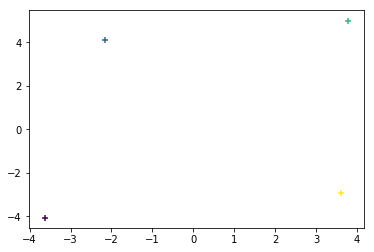

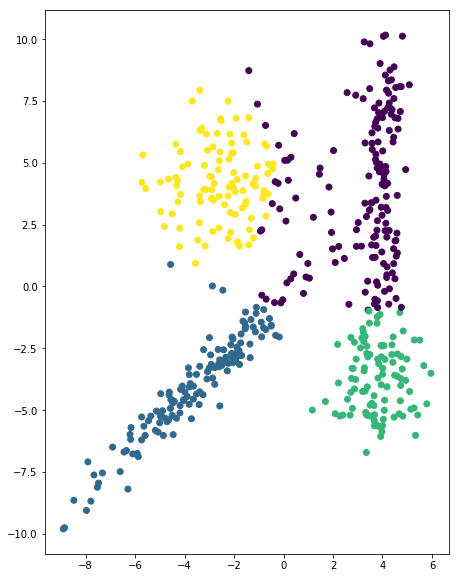

In [1132]:
em = EM(4, covariance_type='id')
lik = em.fit(train)

plt.figure(figsize=(10, 10))
plt.scatter(train[:, 0], train[:, 1], c=em.predict(train))
plt.gca().set_aspect('equal', adjustable='box')
for i in range(4):
    plt.contour(x, y, gaussian_density(em.mu[i, :], em.sigma[i, :, :])(
    np.concatenate((x.reshape(-1, 1), y.reshape(-1, 1)), 
                   axis=1)).reshape(400, 400), np.linspace(1e-3, 1, 100), alpha=0.4)
    
plt.figure()
plt.plot(lik)

In [1104]:
def plot_GM(method, title, n_gaussians):
    em = EM(n_gaussians, covariance_type=method)
    lik = em.fit(train)
    
    wi = train[:, 0].max() - train[:, 0].min()
    he = train[:, 1].max() - train[:, 1].min()

    x = np.linspace(train[:, 0].min()-0.1*wi, train[:, 0].max()+0.1*wi, 200)
    y = np.linspace(train[:, 1].min()-0.1*he, train[:, 1].max()+0.1*he, 200)
    x, y = np.meshgrid(x, y)

    plt.figure(figsize=(10, 10))
    plt.scatter(train[:, 0], train[:, 1], c=em.predict(train))
    plt.gca().set_aspect('equal', adjustable='box')
    for i in range(n_gaussians):
        plt.contour(x, 
                    y, 
                    gaussian_density(em.mu[i, :], em.sigma[i, :, :])(
                        np.concatenate((x.reshape(-1, 1), y.reshape(-1, 1)), 
                        axis=1)).reshape(len(x), len(y)), 
                    np.linspace(1e-3, 1, 100), 
                    alpha=0.3)
        
    plt.savefig(title + '.pdf')

/Users/hugo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in log


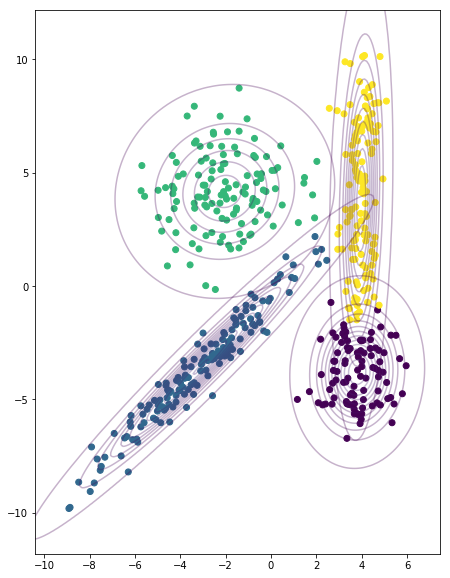

In [1106]:
plot_GM('full', 'test', 4)

/Users/hugo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in log


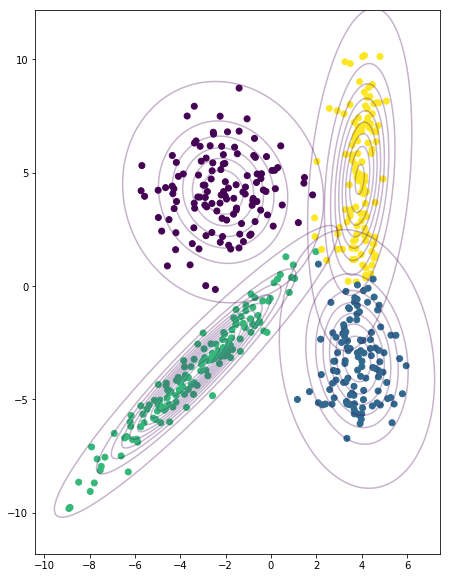

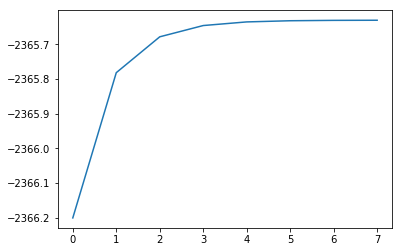

In [1098]:
n_gaussians = 4
em = EM(n_gaussians, covariance_type='diag')
lik = em.fit(train)

wi = train[:, 0].max() - train[:, 0].min()
he = train[:, 1].max() - train[:, 1].min()

x = np.linspace(train[:, 0].min()-0.1*wi, train[:, 0].max()+0.1*wi, 200)
y = np.linspace(train[:, 1].min()-0.1*he, train[:, 1].max()+0.1*he, 200)
x, y = np.meshgrid(x, y)

plt.figure(figsize=(10, 10))
plt.scatter(train[:, 0], train[:, 1], c=em.predict(train))
plt.gca().set_aspect('equal', adjustable='box')
for i in range(n_gaussians):
    plt.contour(x, 
                y, 
                gaussian_density(em.mu[i, :], em.sigma[i, :, :])(
                    np.concatenate((x.reshape(-1, 1), y.reshape(-1, 1)), 
                    axis=1)).reshape(len(x), len(y)), 
                np.linspace(1e-3, 1, 100), 
                alpha=0.3)
    
plt.figure()
plt.plot(lik)

/Users/hugo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in log


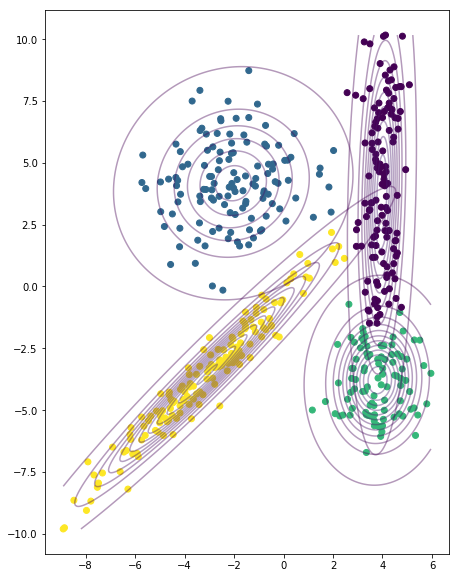

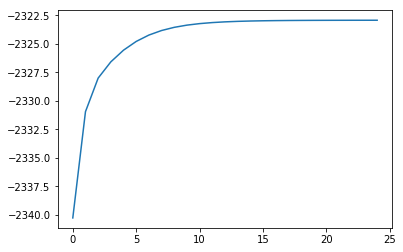

In [1086]:
em = EM(4, covariance_type='full')
lik = em.fit(train)



plt.figure(figsize=(10, 10))
plt.scatter(train[:, 0], train[:, 1], c=em.predict(train))
plt.gca().set_aspect('equal', adjustable='box')
for i in range(4):
    plt.contour(x, y, gaussian_density(em.mu[i, :], em.sigma[i, :, :])(
    np.concatenate((x.reshape(-1, 1), y.reshape(-1, 1)), 
                   axis=1)).reshape(400, 400), np.linspace(1e-3, 1, 100), alpha=0.4)
    
plt.figure()
plt.plot(lik)